You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

***stores.csv***

This file contains anonymized information about the 45 stores, indicating the type and size of store.

***train.csv***

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

* Store - the store number

* Dept - the department number

* Date - the week

* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week


***test.csv***

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

***features.csv***

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week
  For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',font_scale=1.3)
color = sns.color_palette()
pd.options.display.max_columns=100 # to see columns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [3]:
train['Date']=pd.DatetimeIndex(train.Date)
features['Date'] = pd.DatetimeIndex(features.Date)

# 1. Data Cleaning 

### Merging Dataframes

In [4]:
df_1 = features.merge(stores, on='Store', how='left')
df_1.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
df = train.merge(df_1, on=['Store','Date','IsHoliday'], how='left')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


### Create 'Week' ,'Year' from date

In [6]:
df['Week'] = df.Date.dt.week
df['Year'] = df.Date.dt.year

In [7]:
df.shape

(421570, 18)

## Looking at columns

In [8]:
df['Store'].nunique()

45

In [9]:
df['Dept'].nunique()

81

In [10]:
df['Dept'].max()

99

there are 45 stores and within stores there are 81 Departments(labeled from 1 to 99 , some Department numbers are missing )

Now, I will look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores.

In [11]:
Store_Dept_table = pd.pivot_table(index='Store',columns='Dept',
                                  values='Weekly_Sales',data=df,aggfunc=np.mean )
#by default np.mean is applied
display(Store_Dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81.

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values

In [12]:
df.loc[df['Weekly_Sales']<0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315,32,2012
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315,18,2012
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315,10,2010
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315,40,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221,6,2010
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221,7,2010
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221,15,2010
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221,26,2010


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [13]:
df  = df.loc[df['Weekly_Sales']> 0]

# 2. Exploratory Data Analysis

## IsHoliday Column

Text(0.5, 1.0, 'Weekly_sales with respect to IsHoliday')

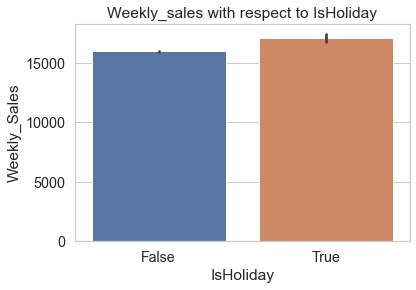

In [14]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)
plt.title('Weekly_sales with respect to IsHoliday')

In [15]:
holidays = df[df['IsHoliday']==True]
holidays['Date'].unique()

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

here are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12

In [16]:
Not_holidays = df[df['IsHoliday']!=True]
Not_holidays['Date'].nunique()

133

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

In [17]:
# Make new column Super_bowl iand set dates in train set to true , other dates to False

df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [18]:
## Make new column Labour_day iand set dates in train set to true , other dates to False

df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [19]:
## Make new column Thanksgiving iand set dates in train set to true , other dates to False

df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [20]:
## Make new column Christmas iand set dates in train set to true , other dates to False

df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

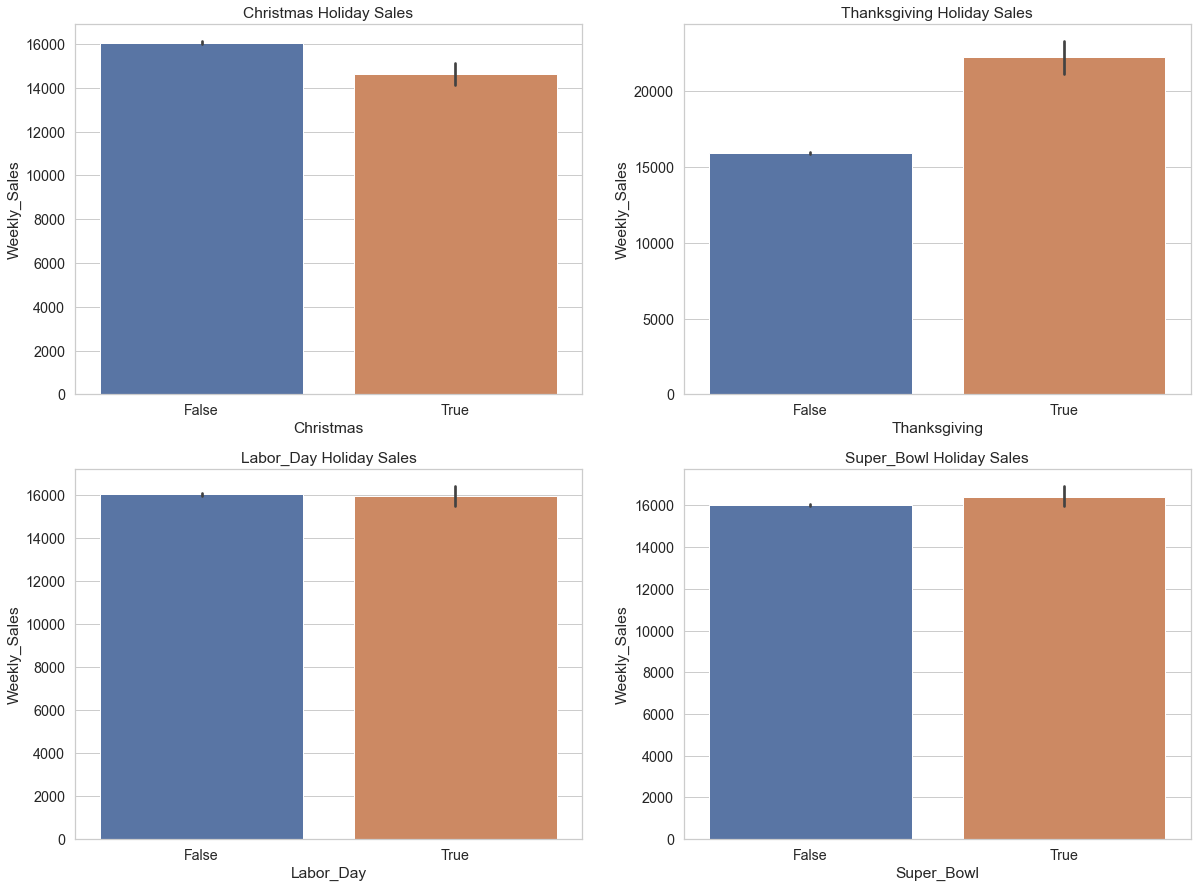

In [21]:
plt.figure(figsize=(20,15))
plt.subplot(221)
sns.barplot(x='Christmas',y='Weekly_Sales', data=df)
plt.title('Christmas Holiday Sales')

plt.subplot(222)
sns.barplot(x='Thanksgiving',y='Weekly_Sales', data=df)
plt.title('Thanksgiving Holiday Sales')

plt.subplot(223)
sns.barplot(x='Labor_Day',y='Weekly_Sales', data=df)
plt.title('Labor_Day Holiday Sales')

plt.subplot(224)
sns.barplot(x='Super_Bowl',y='Weekly_Sales', data=df)
plt.title('Super_Bowl Holiday Sales')
plt.show()

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

## Type Effect on Holidays

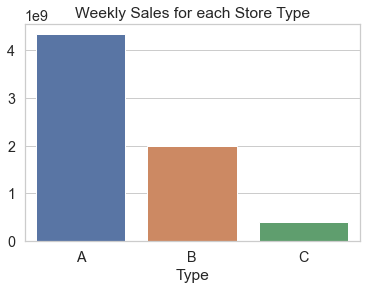

In [22]:
temp = df.groupby(['Type']).Weekly_Sales.sum()
sns.barplot(temp.index, temp.values)
plt.title('Weekly Sales for each Store Type');

We can see that Type A Stores has the highest sales

In [23]:
Type_Christmas = (df.groupby(['Christmas','Type']).Weekly_Sales.mean().reset_index())
Type_Christmas = Type_Christmas[Type_Christmas['Christmas']==True]

Type_Super_Bowl = df.groupby(['Super_Bowl','Type']).Weekly_Sales.mean().reset_index()
Type_Super_Bowl = Type_Super_Bowl[Type_Super_Bowl['Super_Bowl']==True]

Type_Labor_Day = df.groupby(['Labor_Day','Type']).Weekly_Sales.mean().reset_index()
Type_Labor_Day = Type_Labor_Day[Type_Labor_Day['Labor_Day']==True]

Type_Thanksgiving = df.groupby(['Thanksgiving','Type']).Weekly_Sales.mean().reset_index()
Type_Thanksgiving = Type_Thanksgiving[Type_Thanksgiving['Thanksgiving']==True]


In [24]:
temp = pd.concat([Type_Thanksgiving,Type_Labor_Day,Type_Super_Bowl,Type_Christmas])[['Type','Weekly_Sales']].reset_index(drop=True)
temp['Holiday'] = np.array(['Thanksgiving','Thanksgiving','Thanksgiving','Labor_Day','Labor_Day','Labor_Day',
                             'Super_Bowl','Super_Bowl','Super_Bowl','Christmas','Christmas','Christmas'])

Text(0.5, 1.0, 'Distribution of weekly sales in holiday week')

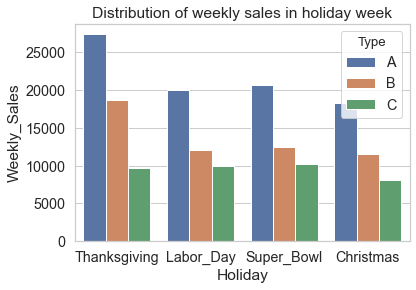

In [25]:
sns.barplot(x='Holiday', y='Weekly_Sales', hue='Type', data=temp)
plt.title('Distribution of weekly sales in holiday week')

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [26]:
df.sort_values(by='Weekly_Sales', ascending=False).head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,47,2010,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,47,2011,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,47,2011,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,47,2010,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,47,2010,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales belongs to Thanksgiving weeks.

# Size column

Size column represent the size of every store

Text(0.5, 1.0, 'Size of Each Store')

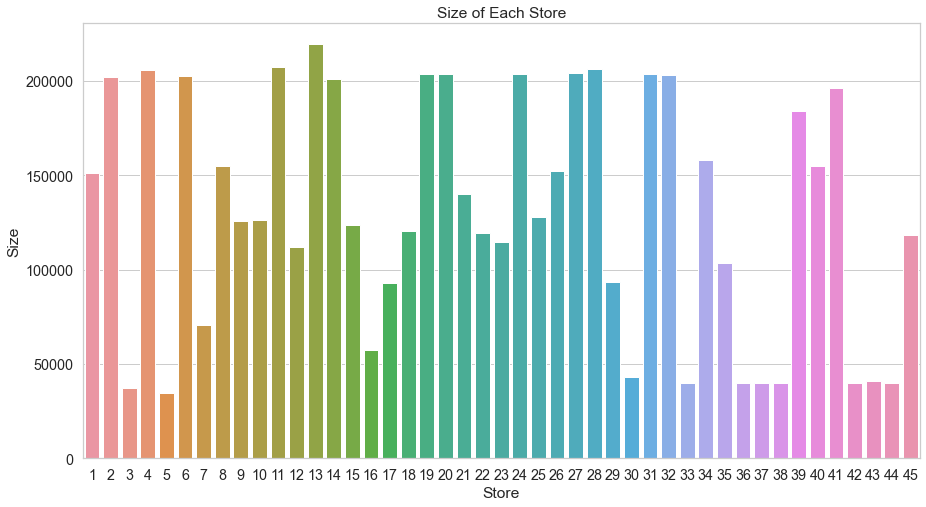

In [27]:
plt.figure(figsize=(15,8))
temp = df[['Store','Size']].sort_values(by='Size', ascending=False)
order = temp['Store']
sns.barplot(x='Store',y='Size', data=temp)
plt.title("Size of Each Store")

we can See that Store 13 has the Largest size followed by 2,4 ,6,11, etc

## Size -Type relationship

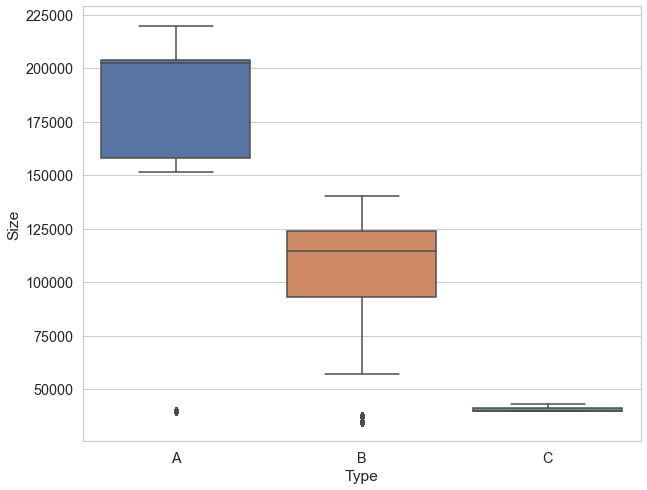

In [28]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Type', y='Size',data=df )

As seen, the store Type with highest sales has the highest size. Walmart classifies their stores Size according to above graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

## Markdown columns

Walmart gave markdown columns to see the effect of markdown on sales. No markdown are have NAN values . lets replace NAN with 0 indicating no markdown on that date.

In [29]:
df[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']] =\
                        df[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

In [30]:
df.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2       False
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
Week            False
Year            False
Super_Bowl      False
Labor_Day       False
Thanksgiving    False
Christmas       False
dtype: bool

### Lets see the effect of markdown on Sales

In [31]:
temp = df[['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']].any(axis=1) 
df['MarkDown'] = [1 if x==True else 0 for x in temp.values]

In [32]:
df['MarkDown'].value_counts()

0    269283
1    150929
Name: MarkDown, dtype: int64

,MarkDown,Weekly_Sales
0,0,15922.137810
1,1,16231.116041


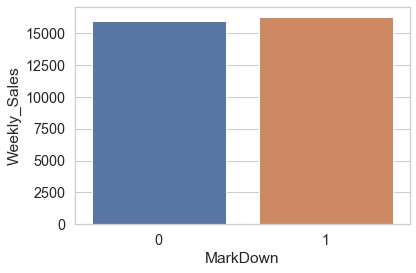

In [33]:
temp = df.groupby(['MarkDown']).Weekly_Sales.mean().reset_index()
sns.barplot('MarkDown','Weekly_Sales',data=temp)
temp

We can see that Average Sales of  week with Markdown is more as compared to Average Sales of week with no markdowns

## Effect of CPI, Unemployment, Fuel_Price, Temperature  on Weekly_Sales

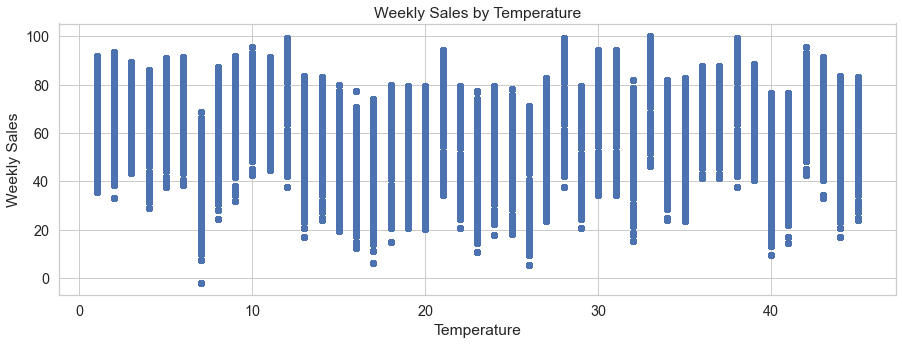

In [34]:
x=df['Store']
y=df['Temperature']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

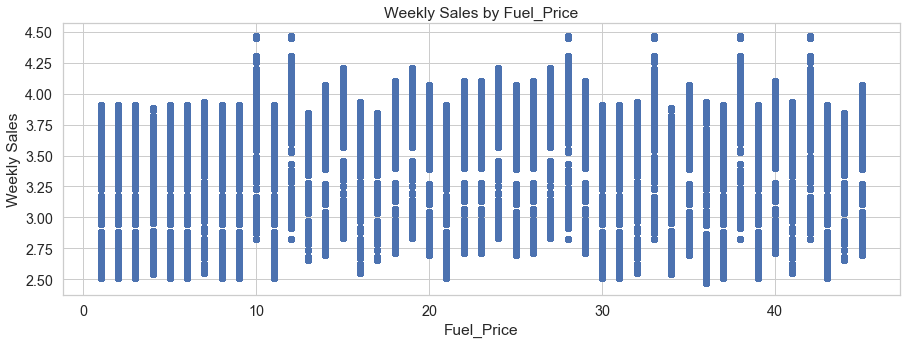

In [35]:
x=df['Store']
y=df['Fuel_Price']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Fuel_Price')
plt.xlabel('Fuel_Price')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

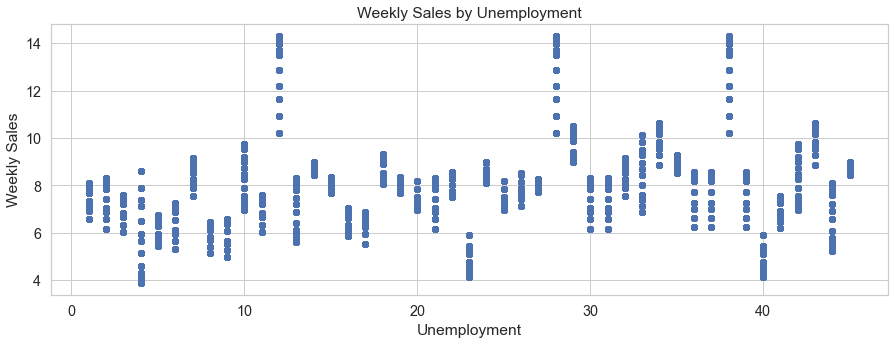

In [102]:
x=df['Store']
y=df['Unemployment']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

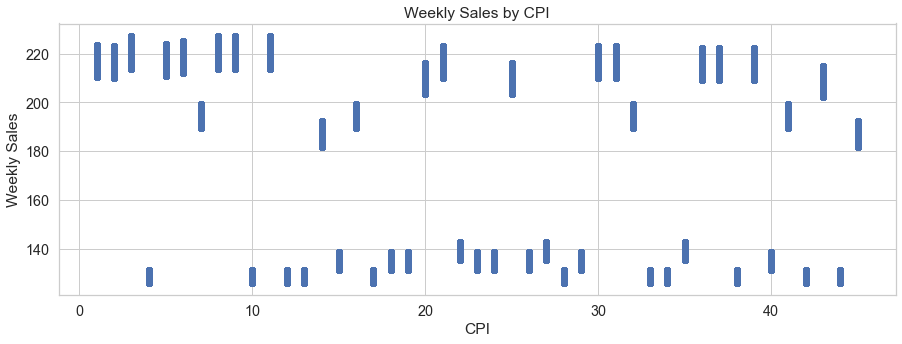

In [103]:
x=df['Store']
y=df['CPI']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by CPI')
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

From all the 4 figures above we can see that CPI, Unemployment, Fuel_Price, Temperature has no effect on Weekly Sales

## Deeper Look in to Sales

### Sales for Stores

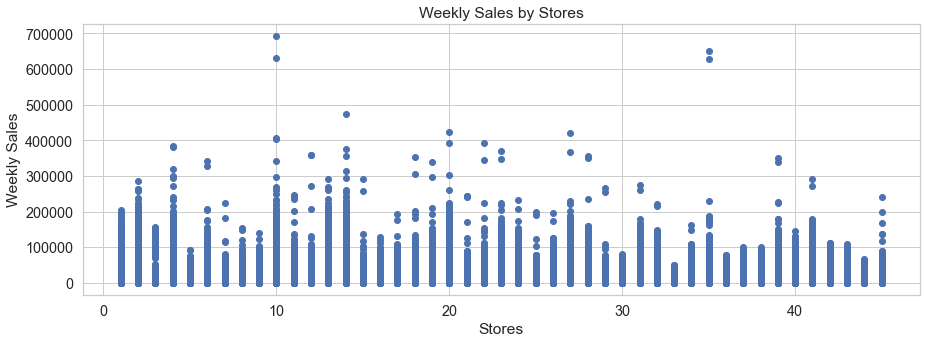

In [49]:
# sales for Every Store

x=df['Store']
y=df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

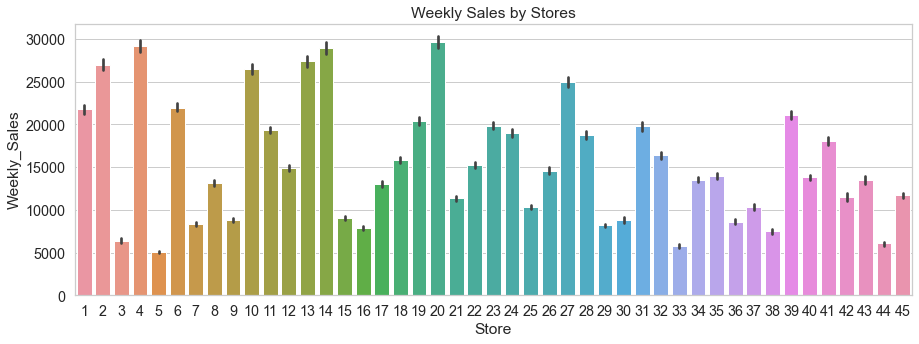

In [48]:
x=df['Store']
y=df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
sns.barplot(x,y)
plt.show()

from Above two figures we can see that all the stores have performed well in weekly sales. but when we take average sales for each store Store 20, 4,14 has the highest sales.the reason behind this can be Store 20, 4 and 14 has large Size compared to other. however not every Store having large Size have High average sales. 

### Sales for Department

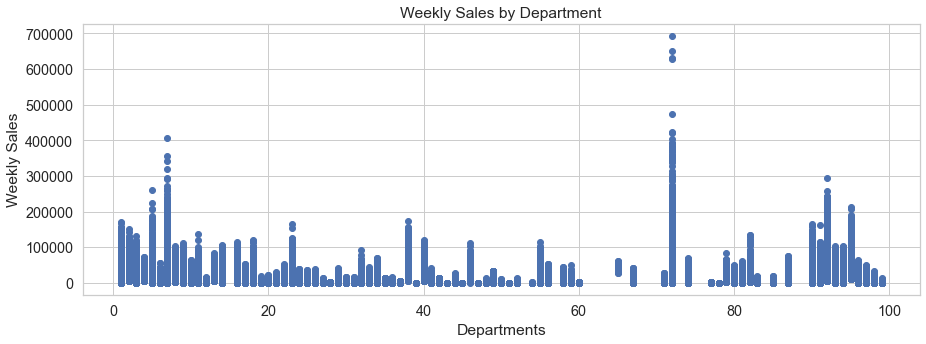

In [46]:
x=df['Dept']
y=df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

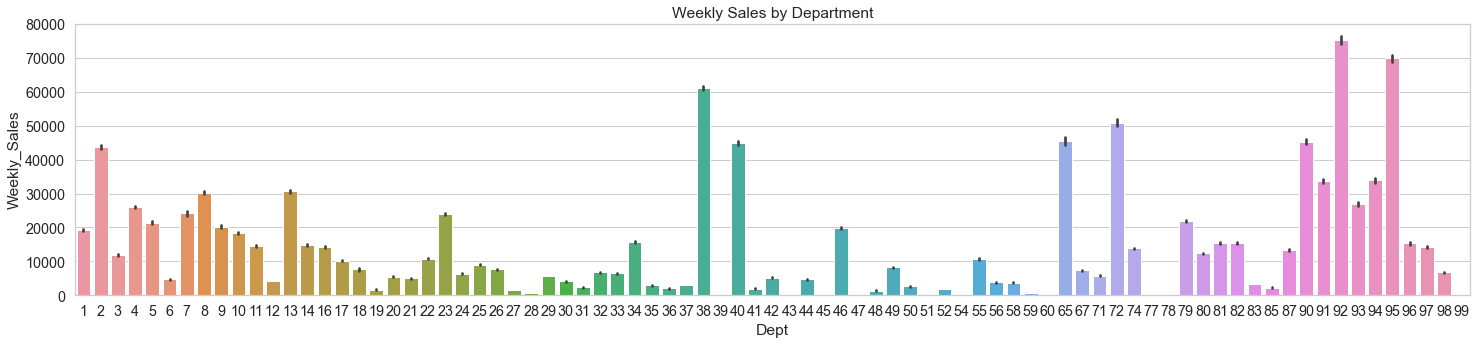

In [52]:
x=df['Dept']
y=df['Weekly_Sales']
plt.figure(figsize=(25,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
sns.barplot(x,y)
plt.show()

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher

### Average Weekly Sales for Year 2010, 2011, 2012 

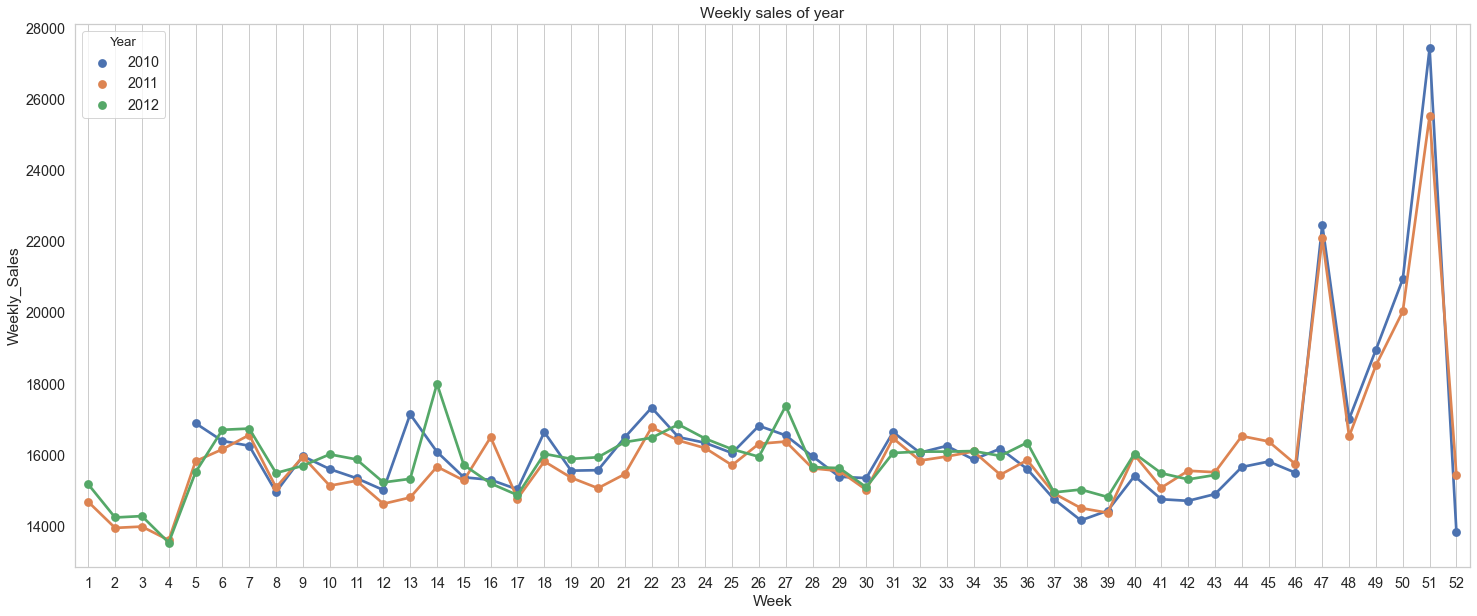

In [55]:
temp = (df
         .groupby(['Year','Week'])
         .Weekly_Sales.mean()
         .reset_index())

plt.figure(figsize=(25,10))
sns.pointplot(x='Week', y='Weekly_Sales',hue = 'Year' ,data=temp)
plt.title('Weekly sales of year')
plt.grid()

From above Graph we can see that week 47, 51 and 50 have higher Avergae Sales due to Thanksgiving, Blackfriday, Christmas effect

As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012



Also year 2012, has higher sales compared to 2010, 2011 but the data for month November and december is not available .

## One hot encoding categorical variables

In [36]:
# replace False and True in columns with 0 and 1
df.replace(to_replace=False, value=0,inplace=True)
df.replace(to_replace=True, value=1,inplace=True)

# Encode Type column
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df['Type'] = df['Type'].map(type_group)

In [37]:
# encoding Type feature
type_dummies = pd.get_dummies(df['Type'],prefix='Type')
df = pd.concat([df,type_dummies], axis=1)

# encoding Store feature
store_feature = pd.get_dummies(df['Store'], prefix='Store')
df = pd.concat([df,store_feature], axis=1)

# encoding Department feature
Dept_feature = pd.get_dummies(df['Dept'], prefix='Dept')
df = pd.concat([df,Dept_feature], axis=1)

# encoding Week feature
Week_feature = pd.get_dummies(df['Week'], prefix='Week')
df = pd.concat([df,Week_feature], axis=1)



# Correlation of features

In [38]:
df_new = (df.sort_values(by='Date')).copy()

In [176]:
drop_features = ['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI',
                  'Unemployment', 'Fuel_Price', 'Temperature','IsHoliday','Type',
                  'Date','Week','Dept','Store','Year']

df_new.drop(columns=drop_features,inplace=True)

In [177]:
# df_corr  = df_new.corr() 

In [178]:
# plt.figure(figsize=(20,10))
# sns.heatmap(df_corr, linewidth=0.1)
# plt.title('Correlation Map')

In [183]:
features = df_new.columns.tolist()
features

['Weekly_Sales',
 'Size',
 'Super_Bowl',
 'Labor_Day',
 'Thanksgiving',
 'Christmas',
 'MarkDown',
 'Type_1',
 'Type_2',
 'Type_3',
 'Store_1',
 'Store_2',
 'Store_3',
 'Store_4',
 'Store_5',
 'Store_6',
 'Store_7',
 'Store_8',
 'Store_9',
 'Store_10',
 'Store_11',
 'Store_12',
 'Store_13',
 'Store_14',
 'Store_15',
 'Store_16',
 'Store_17',
 'Store_18',
 'Store_19',
 'Store_20',
 'Store_21',
 'Store_22',
 'Store_23',
 'Store_24',
 'Store_25',
 'Store_26',
 'Store_27',
 'Store_28',
 'Store_29',
 'Store_30',
 'Store_31',
 'Store_32',
 'Store_33',
 'Store_34',
 'Store_35',
 'Store_36',
 'Store_37',
 'Store_38',
 'Store_39',
 'Store_40',
 'Store_41',
 'Store_42',
 'Store_43',
 'Store_44',
 'Store_45',
 'Dept_1',
 'Dept_2',
 'Dept_3',
 'Dept_4',
 'Dept_5',
 'Dept_6',
 'Dept_7',
 'Dept_8',
 'Dept_9',
 'Dept_10',
 'Dept_11',
 'Dept_12',
 'Dept_13',
 'Dept_14',
 'Dept_16',
 'Dept_17',
 'Dept_18',
 'Dept_19',
 'Dept_20',
 'Dept_21',
 'Dept_22',
 'Dept_23',
 'Dept_24',
 'Dept_25',
 'Dept_26',
 

# Metric for the dataset

Our metric for this project is weighted mean absolute error (WMAE):
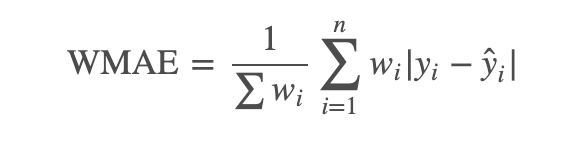

where,

* n is the number of rows
* ŷ i is the predicted sales
* yi is the actual sales
* wi are weights. w = 5 if the week is a holiday week, 1 otherwise

With this metric, the error at holiday weeks has 5 times weight more than normal weeks. So, it is more important to predict sales at holiday weeks accurately. All results for trails can be found at the end of this notebook.

In [39]:
def wmse_test(test, pred): # WMAE for test
    temp = X_test[['Super_Bowl','Labor_Day','Thanksgiving','Christmas']]
    isHoliday = pd.DataFrame(temp).any(axis=1)
    weights = isHoliday.apply(lambda x : 5 if x ==True else 1)
    error = np.sum(weights * np.abs(test-pred), axis=0) / np.sum(weights)
    return error

# Creating Train -Test splits

In [40]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

Train (294148, 204)
Test (126064, 204)


In [41]:
target = 'Weekly_Sales'
used_cols = [c for c in df_new.columns.tolist() if c != target ]

# assign train-test X-y values
X_train = train_data[used_cols]
y_train = train_data[target]**(1/3)
X_test = test_data[used_cols]
y_test = test_data[target]**(1/3)

# Random Forest Regressor

To tune the regressor, I can use gridsearch but it takes too much time for this type of data which has many rows and columns. So, I choose regressor parameters manually. I changed the parameters each time and try to find the best result.

In [297]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1, 
                           max_depth=12, max_features = 'sqrt',min_samples_split = 10,
                           verbose=1)
scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [298]:
wmse_test(y_test**3, y_pred**3)

9377.172406489073

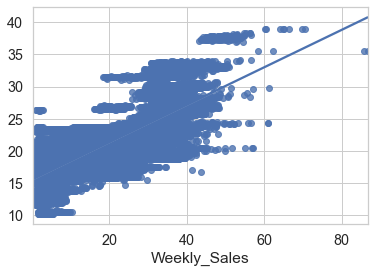

In [299]:
sns.regplot(y_test,y_pred )

In [264]:
mean_absolute_error(y_test, y_pred)


10601.514682540537

In [260]:
rf.score(X_test,y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


0.47548484680647246

In [265]:
feature_imp = pd.DataFrame({'Features':features[:-1], 'Importance':rf.feature_importances_}).sort_values(by='Importance',ascending=False)

In [266]:
temp = pd.concat([feature_imp.head(60)], axis=0)
temp_features = temp.Features.tolist()
temp_features

['Dept_91',
 'Dept_94',
 'Dept_37',
 'Weekly_Sales',
 'Dept_71',
 'Dept_39',
 'Dept_87',
 'MarkDown',
 'Dept_1',
 'Type_1',
 'Dept_90',
 'Store_9',
 'Dept_93',
 'Type_2',
 'Labor_Day',
 'Store_13',
 'Dept_12',
 'Store_19',
 'Week_46',
 'Dept_7',
 'Dept_92',
 'Dept_27',
 'Store_3',
 'Week_50',
 'Dept_58',
 'Dept_6',
 'Dept_52',
 'Store_32',
 'Store_12',
 'Store_1',
 'Dept_59',
 'Dept_26',
 'Store_2',
 'Dept_51',
 'Dept_40',
 'Store_4',
 'Dept_35',
 'Dept_30',
 'Store_35',
 'Store_22',
 'Store_26',
 'Dept_22',
 'Type_3',
 'Dept_83',
 'Dept_34',
 'Dept_3',
 'Christmas',
 'Store_43',
 'Dept_11',
 'Dept_18',
 'Dept_82',
 'Store_8',
 'Store_34',
 'Store_25',
 'Dept_4',
 'Dept_55',
 'Store_37',
 'Store_42',
 'Dept_29',
 'Store_11']

# Binning Store, Department, Week features

In [186]:
#Stores = 1-9, 10-18 ,18-27, 28-36, 37-45 
temp=[]
for val in df['Store'].values.tolist():
    if ((val>=1) & (val<=9)):
        temp.append(1)
    elif ((val>=10) & (val<=18)):
        temp.append(2)
    elif ((val>=19) & (val<=27)):
        temp.append(3)
    elif ((val>=28) & (val<=36)):
        temp.append(4)
    elif ((val>=37) & (val<=45)):
        temp.append(5)
df['Store_cat'] = temp

temp = pd.get_dummies(df['Store_cat'],prefix='Store_cat')
df = pd.concat([df,temp],axis=1)

In [187]:
#Dept = 1-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-65

temp=[]
for val in df['Dept'].values.tolist():
    if ((val>=1) & (val<=10)):
        temp.append(1)
    elif ((val>=11) & (val<=20)):
        temp.append(2)
    elif ((val>=21) & (val<=30)):
        temp.append(3)
    elif ((val>=31) & (val<=40)):
        temp.append(4)
    elif ((val>=41) & (val<=50)):
        temp.append(5)
    elif ((val>=51) & (val<=60)):
        temp.append(6)
    elif ((val>=61) & (val<=70)):
        temp.append(7)
    elif ((val>=71) & (val<=80)):
        temp.append(8)
    elif ((val>=81) & (val<=90)):
        temp.append(9)
    elif ((val>=91) & (val<=99)):
        temp.append(10)
    

df['Dept_cat'] = temp

temp = pd.get_dummies(df['Dept_cat'],prefix='Dept_cat')
df = pd.concat([df,temp],axis=1)

In [188]:
#week = 1-10, 11-20, 21-30, 31-40, 41-48, 49-52

temp=[]
for val in df['Week'].values.tolist():
    if ((val>=1) & (val<=10)):
        temp.append(1)
    elif ((val>=11) & (val<=20)):
        temp.append(2)
    elif ((val>=21) & (val<=30)):
        temp.append(3)
    elif ((val>=31) & (val<=40)):
        temp.append(4)
    elif ((val>=41) & (val<=48)):
        temp.append(5)
    elif ((val>=49) & (val<=52)):
        temp.append(6)
df['Week_cat'] = temp


temp = pd.get_dummies(df['Week_cat'],prefix='Week_cat')
df = pd.concat([df,temp],axis=1)

### using Store and Dept variables as Continuous features, Removing IsHoliday feature


In [314]:
feature_set2 = ['Store', 'Dept', 'Size', 'Super_Bowl', 'Labor_Day', 'Thanksgiving',
                 'Christmas',  'MarkDown', 'Week_cat_1', 'Week_cat_2', 'Week_cat_3', 'Week_cat_4',
                 'Week_cat_5','Type_1','Type_2']

In [315]:
df_new = (df.sort_values(by='Date')).copy()

In [316]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

target = 'Weekly_Sales'

# assign train-test X-y values
X_train = train_data[feature_set2]
y_train = train_data[target]
X_test = test_data[feature_set2]
y_test = test_data[target]

print(X_train.shape, y_train.shape)

Train (294148, 228)
Test (126064, 228)
(294148, 15) (294148,)


In [317]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=5, 
                           max_depth=15,min_samples_split = 10,verbose=1)

scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
# y_train_pred = pipe.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   46.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.7s finished


In [318]:
wmse_test(y_test, y_pred)

4277.601228614386

## removing Holiday variables from above feature_set2

In [308]:
feature_set3 = ['Store', 'Dept', 'IsHoliday', 'Size','MarkDown', 'Week_cat_1', 'Week_cat_2', 'Week_cat_3', 'Week_cat_4',
                 'Week_cat_5','Type_1','Type_2']

In [309]:
df_new = (df.sort_values(by='Date')).copy()

In [310]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

target = 'Weekly_Sales'

# assign train-test X-y values
X_train = train_data[feature_set3]
y_train = train_data[target]
X_test = test_data[feature_set3]
y_test = test_data[target]

print(X_train.shape, y_train.shape)

Train (294148, 228)
Test (126064, 228)
(294148, 12) (294148,)


In [311]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=5, 
                           max_depth=15,min_samples_split = 10,verbose=1)

scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
# y_train_pred = pipe.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.7s finished


In [312]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test.IsHoliday.apply(lambda x : 5 if x ==True else 1)
    error = np.sum(weights * np.abs(test-pred), axis=0) / np.sum(weights)
    return error

In [313]:
wmae_test(y_test, y_pred)

4360.038810342242

### using Store, dept , week as categorical variable

In [303]:
feature_set3 = ['Super_Bowl', 'Labor_Day', 'Thanksgiving','Christmas', 'Size',
                'MarkDown', 'Week_cat_1', 'Week_cat_2', 'Week_cat_3', 'Week_cat_4',
                 'Week_cat_5','Store_cat_1','Store_cat_2','Store_cat_3','Store_cat_4',
                 'Dept_cat_1', 'Dept_cat_2','Dept_cat_3', 'Dept_cat_4', 'Dept_cat_5',
                 'Dept_cat_6', 'Dept_cat_7', 'Dept_cat_8', 'Dept_cat_9','Type_1','Type_2']

In [304]:
df_new = (df.sort_values(by='Date')).copy()

In [305]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

target = 'Weekly_Sales'

# assign train-test X-y values
X_train = train_data[feature_set3]
y_train = train_data[target]
X_test = test_data[feature_set3]
y_test = test_data[target]

print(X_train.shape, y_train.shape)

Train (294148, 228)
Test (126064, 228)
(294148, 26) (294148,)


In [306]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=5, 
                           max_depth=15,min_samples_split = 10,verbose=1)

scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
# y_train_pred = pipe.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   53.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


In [307]:
wmse_test(y_test, y_pred)

12516.858469264402

### using Store, dept , week, Type as Continuous variable

Reference : why to use continuous instead of categorical

* https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/
* https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

In [419]:
feature_set4 = ['Store', 'Dept', 'Size', 'IsHoliday','MarkDown','Week','Type']

In [420]:
df_new = (df.sort_values(by='Date')).copy()

In [421]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

target = 'Weekly_Sales'

# assign train-test X-y values
X_train = train_data[feature_set4]
y_train = train_data[target]
X_test = test_data[feature_set4]
y_test = test_data[target]

print(X_train.shape, y_train.shape)

Train (294148, 228)
Test (126064, 228)
(294148, 7) (294148,)


In [422]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=5, 
                           max_depth=15,min_samples_split = 10,verbose=1)

scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
# y_train_pred = pipe.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.8s finished


In [424]:
wmae_test(y_test, y_pred)

2189.167983943642

In [425]:
metrics.mean_squared_error(y_test,y_pred)

17038376.794225883

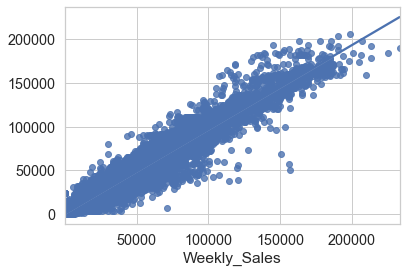

In [355]:
sns.regplot(y_test,y_pred)

### Adding lagged Weekly Sales as feature

In [109]:
df_median = (df.groupby(['Type','Store','Dept','Week','IsHoliday'])
             ['Weekly_Sales'].median()
               )
df_median.head(20)

Type  Store  Dept  Week  IsHoliday
1     1      1     1     0.0          16275.965
                   2     0.0          17127.050
                   3     0.0          17853.285
                   4     0.0          18419.670
                   5     0.0          23510.490
                   6     1.0          37887.170
                   7     0.0          46845.870
                   8     0.0          19403.540
                   9     0.0          20327.610
                   10    0.0          21140.070
                   11    0.0          22136.640
                   12    0.0          22107.700
                   13    0.0          28952.860
                   14    0.0          42960.910
                   15    0.0          28762.370
                   16    0.0          16976.190
                   17    0.0          16555.110
                   18    0.0          17413.940
                   19    0.0          18164.200
                   20    0.0          15136.780
Name:

### Using Linear Regression on features

In [336]:
from sklearn.linear_model import LinearRegression

In [405]:
feature_set3 = ['Super_Bowl', 'Labor_Day', 'Thanksgiving','Christmas', 'Size',
                'MarkDown', 'Week_cat_1', 'Week_cat_2', 'Week_cat_3', 'Week_cat_4',
                 'Week_cat_5','Store_cat_1','Store_cat_2','Store_cat_3','Store_cat_4',
                 'Dept_cat_1', 'Dept_cat_2','Dept_cat_3', 'Dept_cat_4', 'Dept_cat_5',
                 'Dept_cat_6', 'Dept_cat_7', 'Dept_cat_8', 'Dept_cat_9','Type_1','Type_2'] 

In [406]:
df_new = (df.sort_values(by='Date')).copy()

In [407]:
train_data = df_new[: int(0.7* (len(df_new)))]
test_data = df_new[int(0.7 * (len(df_new))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

target = 'Weekly_Sales'

# assign train-test X-y values
X_train = train_data[feature_set3]
y_train = train_data[target]
X_test = test_data[feature_set3]
y_test = test_data[target]

print(X_train.shape, y_train.shape)

Train (294148, 228)
Test (126064, 228)
(294148, 26) (294148,)


In [408]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
pred = linear_model.predict(X_test)

In [409]:
wmse_test(y_test,pred)

12614.010115257917

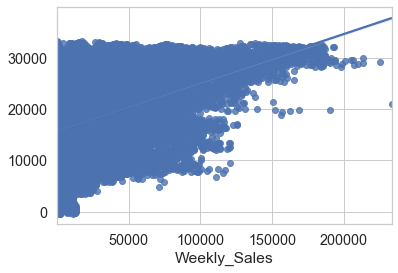

In [378]:
sns.regplot(y_test,pred)


In [413]:
from sklearn.linear_model import Lasso

In [418]:
lasso_model = Lasso(alpha=0.01)

lasso_model.fit(X_train,y_train)
pred = lasso_model.predict(X_test)
wmse_test(y_test,pred)

12614.057740352773

# TIME SERIES MODEL 

# setting date columns as index

In [42]:
df.set_index('Date', inplace=True)

In [43]:
columns_drop = (df.loc[:,'Store_1':]).columns.tolist()

In [44]:
df.drop(columns=columns_drop, inplace=True)

In [45]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Super_Bowl,Labor_Day,Thanksgiving,Christmas,MarkDown,Type_1,Type_2,Type_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,5,2010,0,0,0,0,0,1,0,0
2010-02-12,1,1,46039.49,1.0,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,1,151315,6,2010,1,0,0,0,0,1,0,0
2010-02-19,1,1,41595.55,0.0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,1,151315,7,2010,0,0,0,0,0,1,0,0
2010-02-26,1,1,19403.54,0.0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,1,151315,8,2010,0,0,0,0,0,1,0,0
2010-03-05,1,1,21827.90,0.0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,1,151315,9,2010,0,0,0,0,0,1,0,0


## Plotting Sales

In [46]:
df_week = df.resample('W').mean()
df_week.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Super_Bowl,Labor_Day,Thanksgiving,Christmas,MarkDown,Type_1,Type_2,Type_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-07,22.040394,44.161236,16887.602166,0.0,33.282800,2.717968,0.0,0.0,0.0,0.0,0.0,167.328549,8.578592,1.587916,137381.684997,5.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.511541,0.389002,0.099457
2010-02-14,22.006443,44.331638,16390.912208,1.0,33.370444,2.695955,0.0,0.0,0.0,0.0,0.0,167.401961,8.567855,1.584944,137675.080027,6.0,2010.0,1.0,0.0,0.0,0.0,0.0,0.512377,0.390302,0.097321
2010-02-21,22.044444,44.287542,16255.185970,0.0,37.032596,2.673506,0.0,0.0,0.0,0.0,0.0,167.386208,8.574593,1.587879,137277.810101,7.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.510438,0.391246,0.098316
2010-02-28,22.021088,44.058844,14955.932194,0.0,38.624806,2.685486,0.0,0.0,0.0,0.0,0.0,167.708233,8.562094,1.587755,137365.977551,8.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.510544,0.391156,0.098299
2010-03-07,22.056199,44.019755,15964.821240,0.0,42.367490,2.731923,0.0,0.0,0.0,0.0,0.0,167.680036,8.573890,1.585831,137556.273161,9.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.513283,0.387602,0.099114


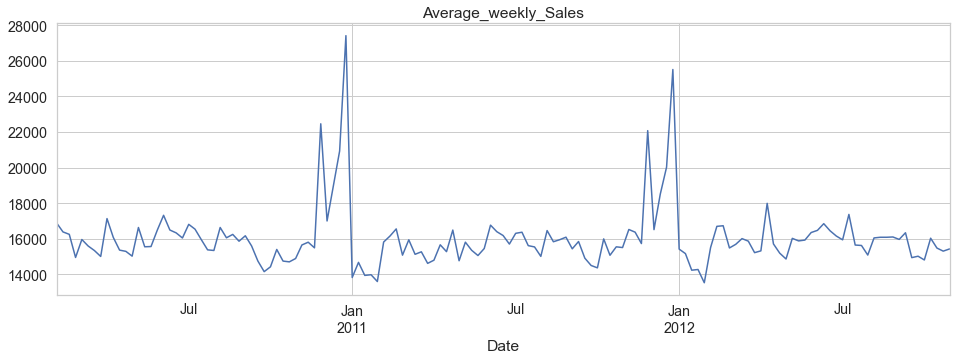

In [47]:
plt.figure(figsize=(16,5))
df_week['Weekly_Sales'].plot()
plt.title('Average_weekly_Sales')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [48]:
df_month = df.resample('MS').mean()   # resample monthly(month Start)
df_month.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Super_Bowl,Labor_Day,Thanksgiving,Christmas,MarkDown,Type_1,Type_2,Type_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01,22.028124,44.210080,16123.339183,0.249809,35.578510,2.693193,0.0,0.0,0.0,0.0,0.0,167.455953,8.570795,1.587124,137424.932232,6.500127,2010.0,0.249809,0.0,0.0,0.0,0.0,0.511224,0.390428,0.098348
2010-03-01,22.076498,44.068584,15480.222209,0.000000,46.695948,2.786435,0.0,0.0,0.0,0.0,0.0,167.557149,8.574451,1.588325,137338.023230,10.500000,2010.0,0.000000,0.0,0.0,0.0,0.0,0.511487,0.388700,0.099813
2010-04-01,22.087864,44.149396,15786.479121,0.000000,56.409791,2.867522,0.0,0.0,0.0,0.0,0.0,167.255377,8.446639,1.588035,137358.674534,14.993929,2010.0,0.000000,0.0,0.0,0.0,0.0,0.511495,0.388976,0.099529
2010-05-01,22.149273,44.298116,16063.976174,0.000000,64.884550,2.917179,0.0,0.0,0.0,0.0,0.0,167.267314,8.451819,1.585047,137351.455218,19.496860,2010.0,0.000000,0.0,0.0,0.0,0.0,0.513551,0.387852,0.098598
2010-06-01,22.218080,44.227551,16551.606753,0.000000,74.595153,2.787978,0.0,0.0,0.0,0.0,0.0,167.634269,8.452569,1.587086,136958.451916,23.501593,2010.0,0.000000,0.0,0.0,0.0,0.0,0.512699,0.387516,0.099785


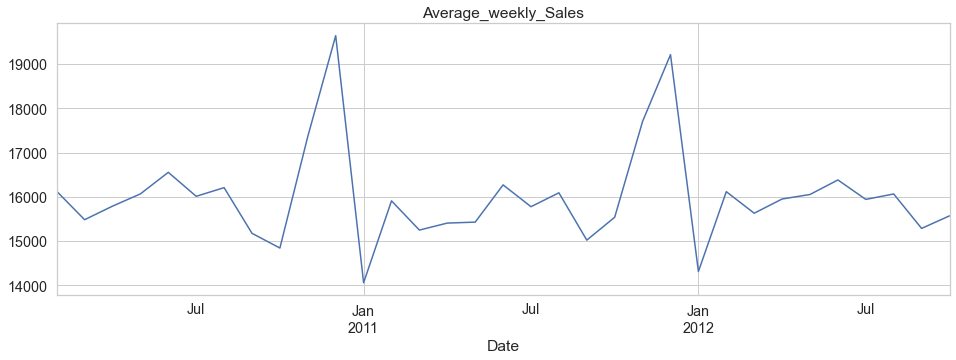

In [49]:
plt.figure(figsize=(16,5))
df_month['Weekly_Sales'].plot()
plt.title('Average_weekly_Sales')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

### To Observe 2-weeks Rolling Mean and Std

In [50]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

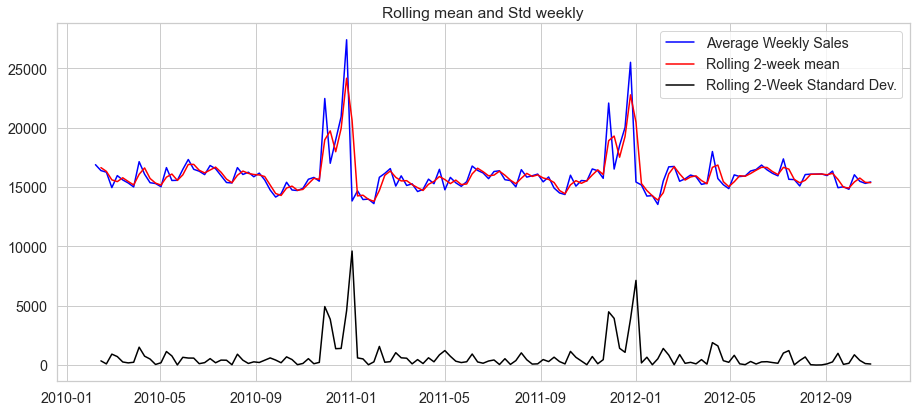

In [51]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue', label='Average Weekly Sales')
ax.plot(roll_mean,color='red', label='Rolling 2-week mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Dev.' )
ax.legend()
ax.set_title('Rolling mean and Std weekly')
fig.tight_layout()

### Adfuller test to make sure that the data is not stationary

In [52]:
from statsmodels.tsa.stattools import adfuller

In [53]:
result = adfuller(df_week['Weekly_Sales'], maxlag=None)
result

(-5.92710722373756,
 2.4290492082043886e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

Observation from ADF test :

[ The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence]

hence Alternalte hypothesis (The series has no unit root) is True. that is Series is Stationary.

Reference:
* https://medium.com/wwblog/stationarity-testing-using-the-augmented-dickey-fuller-test-8cf7f34f4844
* https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
* https://machinelearningmastery.com/time-series-data-stationary-python/
* https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

### KPSS test for finding stationarity

In [54]:
from statsmodels.tsa.stattools import kpss

In [55]:
kpsstest = kpss(df['Weekly_Sales'], regression='ct')

kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            0.319486
p-value                   0.010000
Lags Used                97.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


C:\Users\nehat4\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\nehat4\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Observation from KPSS test :

Test statistic value is greater than critical values, hence Alternalte hypothesis (The series has a unit root (series is not stationary))is True.

From test and observations data is not stationary. 

***KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary***
 

# Train-Test split of weekly data

In [56]:
df_week = df_week.sort_values(by='Date', ascending=True)
df_week.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Super_Bowl,Labor_Day,Thanksgiving,Christmas,MarkDown,Type_1,Type_2,Type_3
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-07,22.040394,44.161236,16887.602166,0.0,33.282800,2.717968,0.0,0.0,0.0,0.0,0.0,167.328549,8.578592,1.587916,137381.684997,5.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.511541,0.389002,0.099457
2010-02-14,22.006443,44.331638,16390.912208,1.0,33.370444,2.695955,0.0,0.0,0.0,0.0,0.0,167.401961,8.567855,1.584944,137675.080027,6.0,2010.0,1.0,0.0,0.0,0.0,0.0,0.512377,0.390302,0.097321
2010-02-21,22.044444,44.287542,16255.185970,0.0,37.032596,2.673506,0.0,0.0,0.0,0.0,0.0,167.386208,8.574593,1.587879,137277.810101,7.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.510438,0.391246,0.098316
2010-02-28,22.021088,44.058844,14955.932194,0.0,38.624806,2.685486,0.0,0.0,0.0,0.0,0.0,167.708233,8.562094,1.587755,137365.977551,8.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.510544,0.391156,0.098299
2010-03-07,22.056199,44.019755,15964.821240,0.0,42.367490,2.731923,0.0,0.0,0.0,0.0,0.0,167.680036,8.573890,1.585831,137556.273161,9.0,2010.0,0.0,0.0,0.0,0.0,0.0,0.513283,0.387602,0.099114


splitting the data manually , not random

In [57]:
train_data = df_week[: int(0.7* (len(df_week)))]
test_data = df_week[int(0.7 * (len(df_week))) : ]

print('Train', train_data.shape)

print('Test', test_data.shape)

Train (100, 25)
Test (43, 25)


In [58]:
target = 'Weekly_Sales'
used_cols = [c for c in df_week.columns.tolist() if c != target ]

# assign train-test X-y values
X_train = train_data[used_cols]
y_train = train_data[target]
X_test = test_data[used_cols]
y_test = test_data[target]

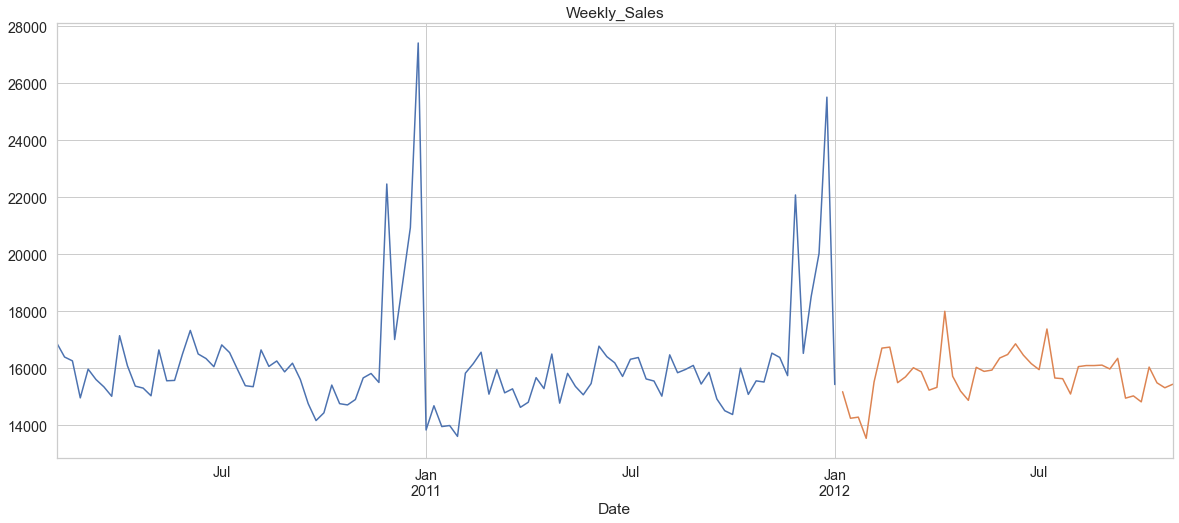

In [59]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title='Weekly_Sales')
test_data['Weekly_Sales'].plot(figsize=(20,8), title='Weekly_Sales')
plt.show()


Blue line represents my train data, yellow is test data

***From the analysis of graphs we can say that the dataset has Seasonal Variation***

Seasonal – It is a pattern that reflects regular fluctuations. These short-term movements occur due to the seasonal factors and custom factors of people. In this case, the data faces regular and predictable changes that occurred at regular intervals of the calendar. It always consists of fixed and known period.

The main sources of seasonality are given below –

* Climate
* Institutions
* Social habits and practices
* Calendar

reference : https://www.xenonstack.com/blog/time-series-deep-learning/

# Decomposing weekly data to observe Seasonality

In [60]:
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

In [61]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

#The additive model is useful when the seasonal variation is relatively constant over time

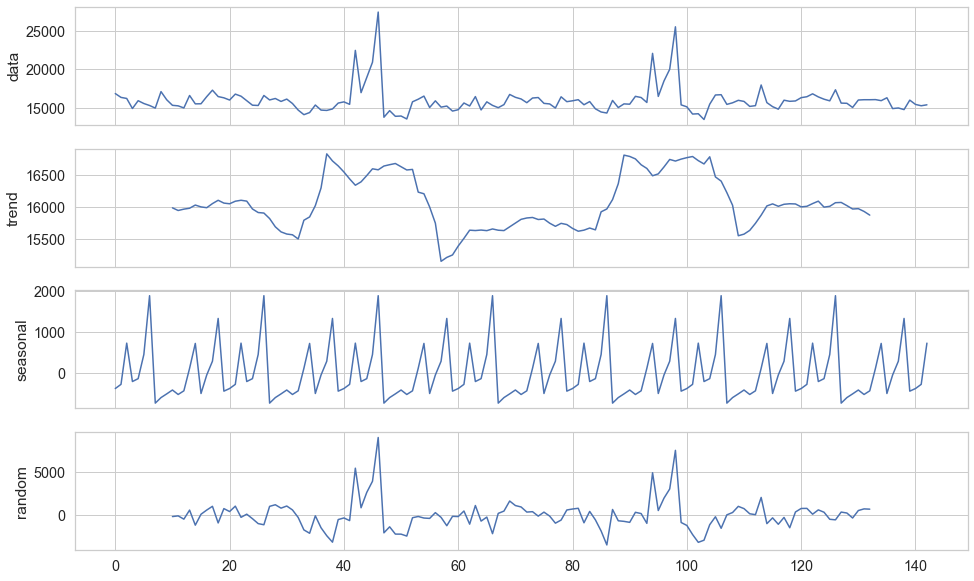

In [62]:
decomposed_plot (decomposed,figure_kwargs={'figsize':(16,10)} )
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model

# Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [63]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() # creating difference values

In [64]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2,center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()


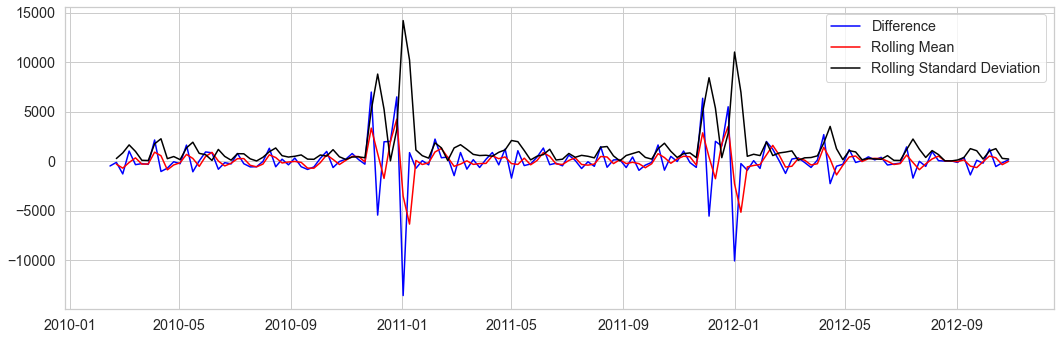

In [65]:
fig, ax= plt.subplots(figsize=(15,5))
ax.plot(df_week_diff, color='blue', label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2. Shift

In [66]:
df_week_lag = df_week['Weekly_Sales'].shift(1).dropna()

In [67]:
# taking mean and std of lagged data
lag_roll_mean = df_week_lag.rolling(window=2,center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

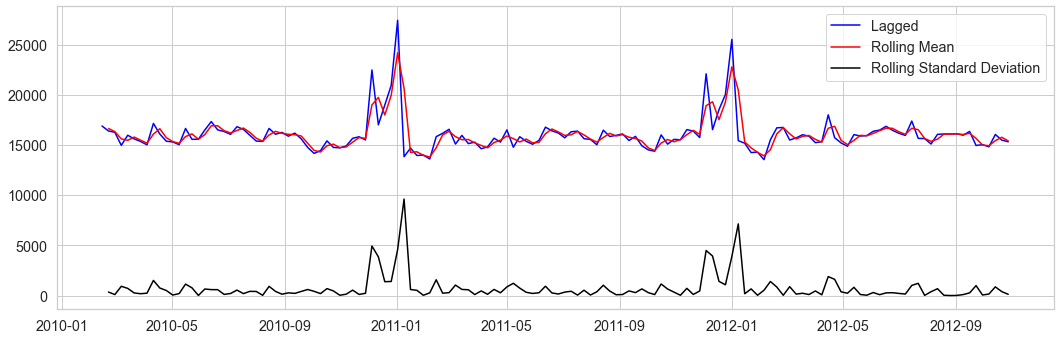

In [68]:
fig, ax= plt.subplots(figsize=(15,5))
ax.plot(df_week_lag, color='blue', label='Lagged')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3. Log

In [69]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [70]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

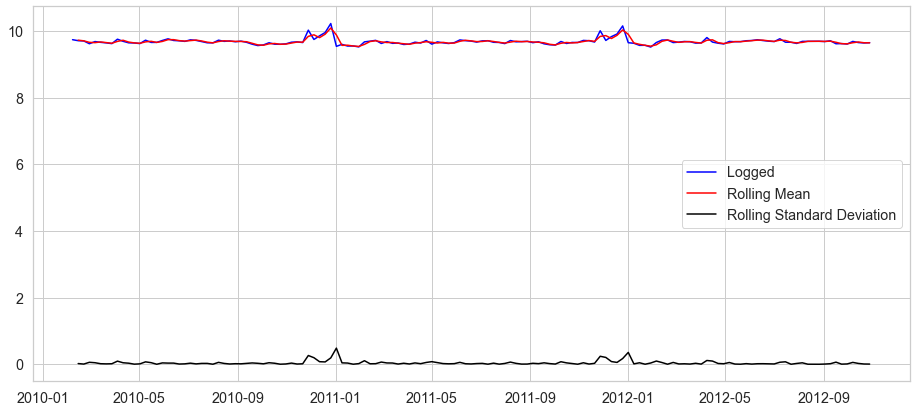

In [71]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Training Model on Auto-Arima

reference :
https://medium.com/analytics-vidhya/walmart-recruiting-store-sales-forecasting-kaggle-competition-856c72c9265a

In [72]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

In [73]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [74]:

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

Fit ARIMA(0,0,0)x(0,0,0,1) [intercept=True]; AIC=1826.858, BIC=1832.048, Time=0.511 seconds
Fit ARIMA(0,0,1)x(0,0,0,1) [intercept=True]; AIC=1793.619, BIC=1801.404, Time=0.079 seconds
Fit ARIMA(0,0,2)x(0,0,0,1) [intercept=True]; AIC=1795.532, BIC=1805.912, Time=0.240 seconds
Fit ARIMA(0,0,3)x(0,0,0,1) [intercept=True]; AIC=1793.997, BIC=1806.973, Time=0.323 seconds
Fit ARIMA(0,0,4)x(0,0,0,1) [intercept=True]; AIC=1794.022, BIC=1809.593, Time=0.520 seconds
Fit ARIMA(0,0,5)x(0,0,0,1) [intercept=True]; AIC=1776.663, BIC=1794.828, Time=0.448 seconds
Fit ARIMA(1,0,0)x(0,0,0,1) [intercept=True]; AIC=1804.051, BIC=1811.836, Time=0.020 seconds
Fit ARIMA(1,0,1)x(0,0,0,1) [intercept=True]; AIC=1792.816, BIC=1803.197, Time=0.272 seconds
Fit ARIMA(1,0,2)x(0,0,0,1) [intercept=True]; AIC=1794.966, BIC=1807.941, Time=0.215 seconds
Fit ARIMA(1,0,3)x(0,0,0,1) [intercept=True]; AIC=1784.312, BIC=1799.882, Time=0.527 seconds
Fit ARIMA(1,0,4)x(0,0,0,1) [intercept=True]; AIC=1784.896, BIC=1803.062, Time=0.

ARIMA(maxiter=200, method='lbfgs', order=(0, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

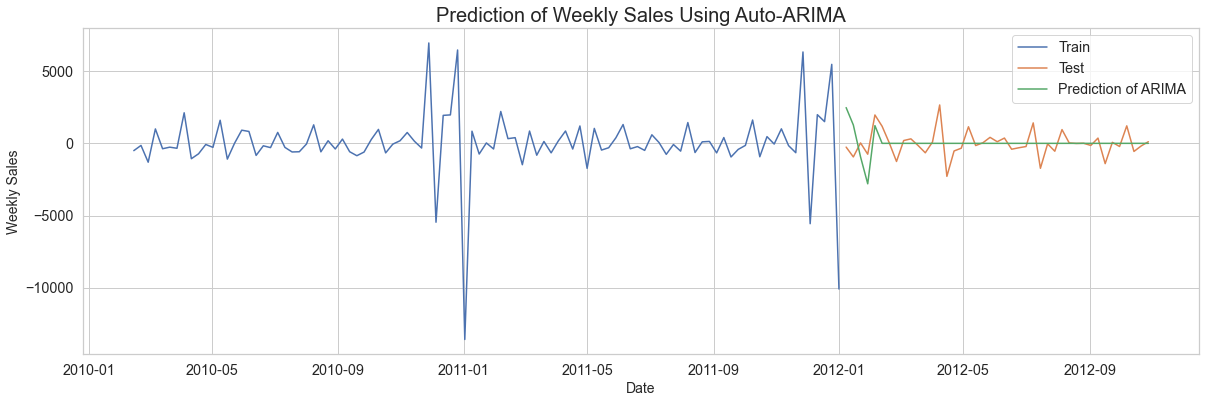

In [75]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data_diff.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

# Exponential Smoothing

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

C:\Users\nehat4\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\nehat4\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


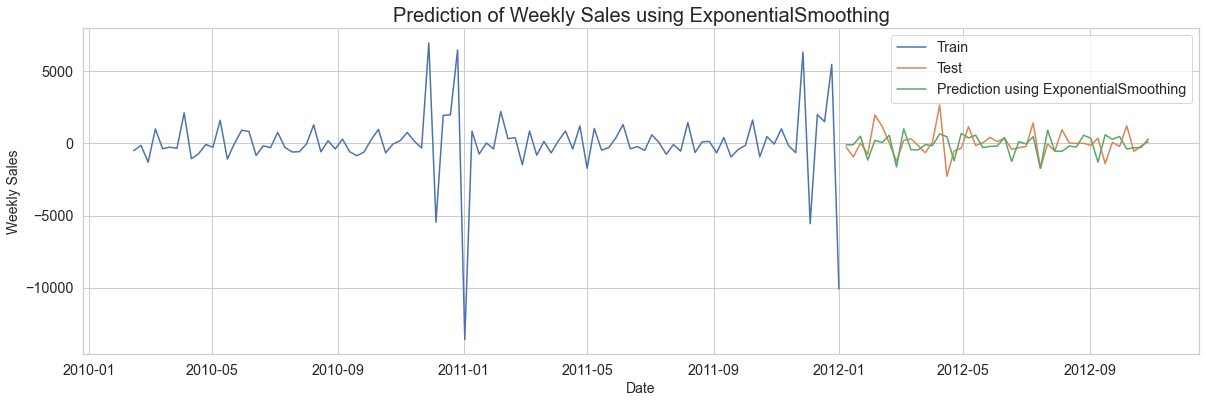

In [77]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=False).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

# Metric

In [78]:
wmse_test(test_data_diff,y_pred)

821.3280930823155

# Trying other Basic Time Series model

### Creating a baseline model for time series

In [79]:
df_week1 = pd.DataFrame(df_week['Weekly_Sales'])

In [80]:
df_week1

,Weekly_Sales
Date,
2010-02-07,16887.602166
2010-02-14,16390.912208
2010-02-21,16255.185970
2010-02-28,14955.932194
2010-03-07,15964.821240
...,...
2012-09-30,14815.621125
2012-10-07,16037.442175
2012-10-14,15484.696200


In [81]:
value = pd.DataFrame(df_week1.Weekly_Sales.shift(1))
value.columns = ['Forecast_Sales']

In [82]:
df_week1 = pd.concat([df_week1 , value], axis=1)
df_week1.head()

,Weekly_Sales,Forecast_Sales
Date,,
2010-02-07,16887.602166,NaN
2010-02-14,16390.912208,16887.602166
2010-02-21,16255.185970,16390.912208
2010-02-28,14955.932194,16255.185970
2010-03-07,15964.821240,14955.932194


In [83]:
df_week1.dropna(inplace=True)

In [84]:
sales_error = metrics.mean_squared_error(df_week1.Weekly_Sales, df_week1.Forecast_Sales)
sales_error

4288332.194449727

In [85]:
np.sqrt(sales_error)

2070.8288665289865

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [87]:
df_week1 = df_week1['Weekly_Sales']

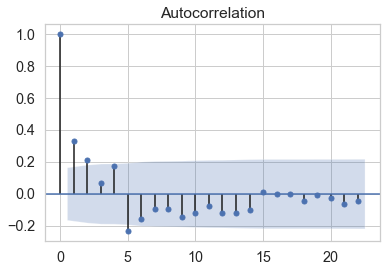

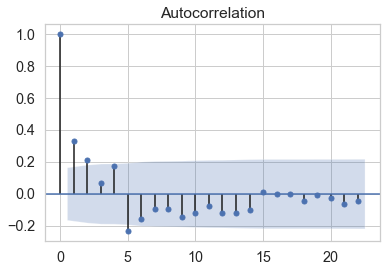

In [88]:
plot_acf(df_week1)

In [89]:
# p = 1,2,5
# q = 1,2,5

In [90]:
train_data_diff = pd.DataFrame(df_week1 [:int(0.7*(len(df_week1 )))])
test_data_diff = pd.DataFrame(df_week1 [int(0.7*(len(df_week1 ))):])

In [91]:
from statsmodels.tsa.arima_model import ARIMA

In [92]:
sales_model = ARIMA(train_data_diff, order=(1,1,1))

In [93]:
sales_model_fit = sales_model.fit()

In [94]:
sales_model_fit.aic

1775.5741481201403

In [95]:
sales_forecast= sales_model_fit.forecast(steps=test_data_diff.shape[0])[0]

In [96]:
sales_forecast

array([16262.28636712, 16530.80285145, 16621.06916312, 16655.45034552,
       16672.31037982, 16683.67717048, 16693.32171523, 16702.42630014,
       16711.36159642, 16720.24381721, 16729.10939774, 16737.96976119,
       16746.82848898, 16755.68670395, 16764.54475815, 16773.40276195,
       16782.26074994, 16791.11873297, 16799.97671445, 16808.83469545,
       16817.69267629, 16826.55065708, 16835.40863786, 16844.26661863,
       16853.12459941, 16861.98258018, 16870.84056095, 16879.69854172,
       16888.55652249, 16897.41450326, 16906.27248404, 16915.13046481,
       16923.98844558, 16932.84642635, 16941.70440712, 16950.56238789,
       16959.42036867, 16968.27834944, 16977.13633021, 16985.99431098,
       16994.85229175, 17003.71027252, 17012.5682533 ])

In [97]:
np.sqrt(mean_squared_error(test_data_diff.Weekly_Sales,sales_forecast))

1325.476000614799